<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Библиотеки" data-toc-modified-id="Библиотеки-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Библиотеки</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Промежуточный-вывод" data-toc-modified-id="Промежуточный-вывод-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Промежуточный вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Статистические-показатели" data-toc-modified-id="Статистические-показатели-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Статистические показатели</a></span></li><li><span><a href="#Визуализация-данных" data-toc-modified-id="Визуализация-данных-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Визуализация данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Промежуточный-вывод" data-toc-modified-id="Промежуточный-вывод-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Промежуточный вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Промежуточный-вывод" data-toc-modified-id="Промежуточный-вывод-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Промежуточный вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
!pip install --upgrade pandas

     |████████████████████████████████| 12.4 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 341 kB 75.1 MB/s eta 0:00:01
     |████████████████████████████████| 247 kB 82.6 MB/s eta 0:00:01
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Uninstalling python-dateutil-2.8.1:
      Successfully uninstalled python-dateutil-2.8.1
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.4
    Uninstalling pandas-1.2.4:
      Successfully uninstalled pandas-1.2.4


In [2]:
!pip install scikit-learn

In [3]:
!pip install lightgbm

## Подготовка

### Библиотеки

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Загрузка данных

In [5]:
data = pd.read_csv("https://code.s3.yandex.net/datasets/taxi.csv", index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим, хранятся ли данные в хронологическом порядке

In [7]:
display(data.index.is_monotonic_increasing)

True

Проведём ресемплирование данных по одному часу

In [8]:
data = data.resample("1H").sum()
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Промежуточный вывод

1. В нашем распоряжении данные от 2018-03-01 00:00:00 до 2018-08-31 23:00:00
2. Данные хранятся в хронологическом порядке
3. Проведено ресемплирование данных по одному часу

## Анализ

### Статистические показатели

Посмотрим ещё раз на данные, найдём верхние/нижние границы

In [9]:
display(data.index.max() - data.index.min())
data.describe()

Timedelta('183 days 23:00:00')

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


1. Минимальное количество заказов - 0
2. Максимальное - 462
3. Данные - сводка по 184 дням и 23 часам

### Визуализация данных

Посмотрим на данные в виде гарфиков в разрере сутки/неделя/месяц

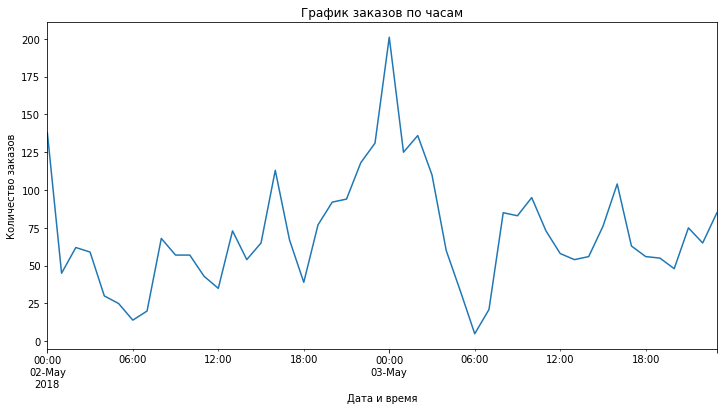

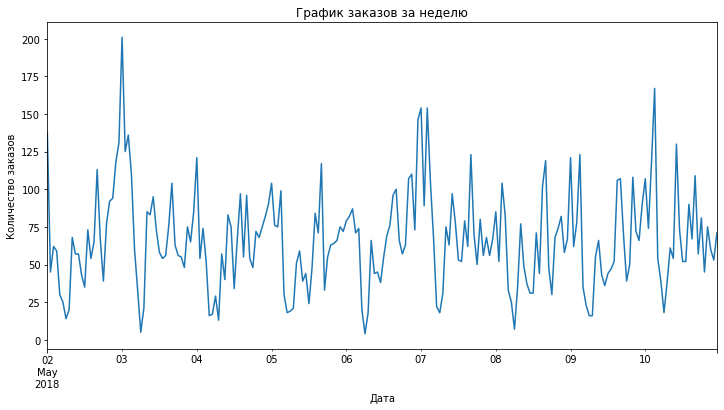

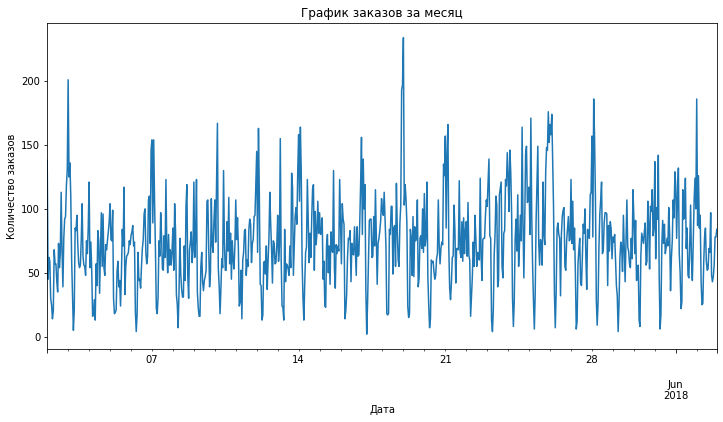

In [10]:
plt.figure(figsize=(12, 6))
data_day = data['2018-05-02':'2018-05-03']
data_day['num_orders'].plot()
plt.title('График заказов по часам')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.show()

data_week = data['2018-05-02':'2018-05-10']
plt.figure(figsize=(12, 6))
data_week['num_orders'].plot()
plt.title('График заказов за неделю')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

data_month = data['2018-05-02':'2018-06-02']
plt.figure(figsize=(12, 6))
data_month['num_orders'].plot()
plt.title('График заказов за месяц')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

- Заметна цикличность в количестве заказов, как в рамках одного дня, так и в рамкаха нескольких дней

Посмотрим на тренд, сезонность и остаток

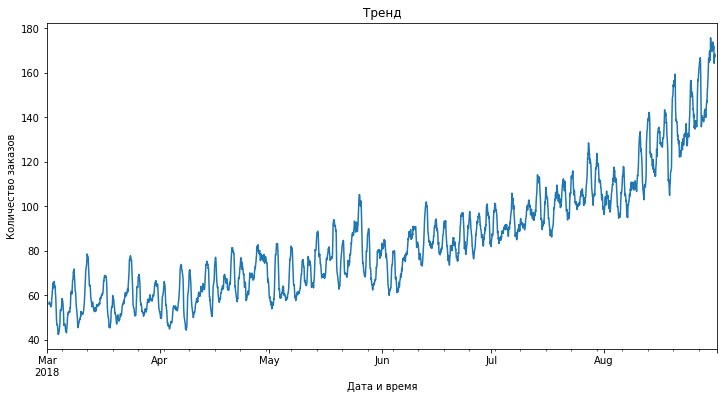

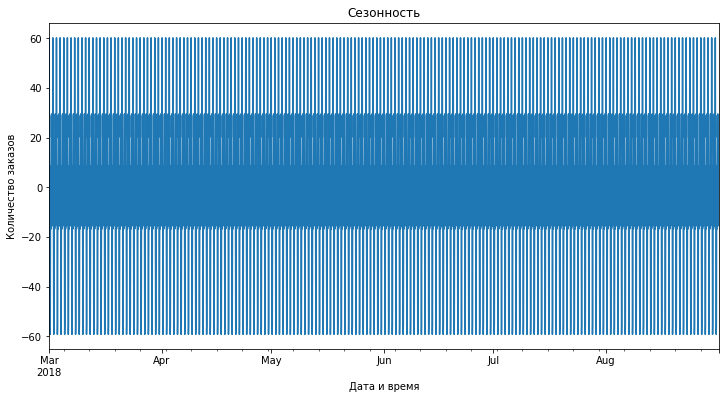

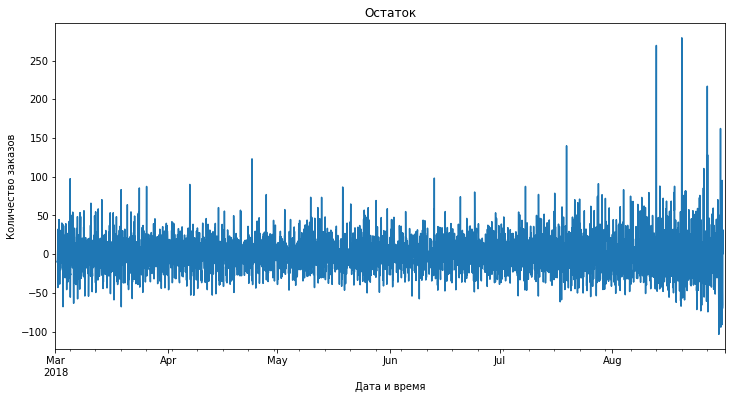

In [11]:
decomposed = seasonal_decompose(data['num_orders'])
plt.figure(figsize=(12, 6))
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.figure(figsize=(12, 6))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.figure(figsize=(12, 6))
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остаток')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.show()

Посмотрим на тренд, сезонность и остаток в рамках 1 недели

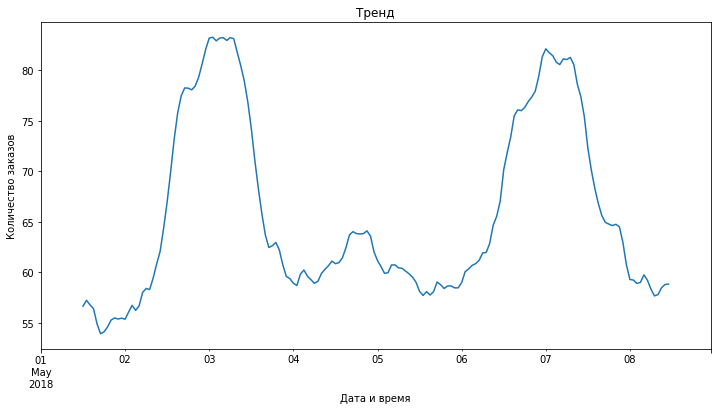

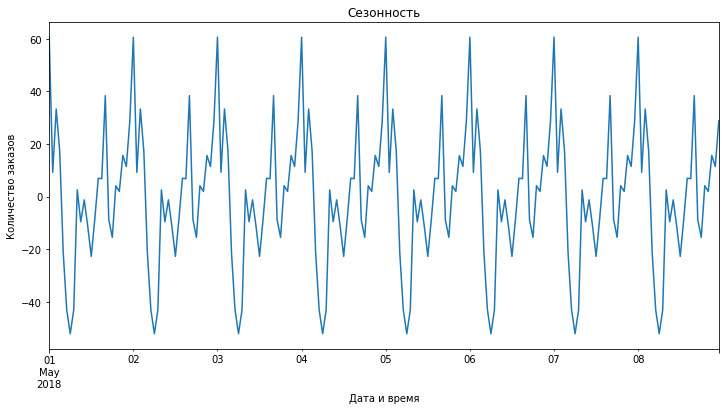

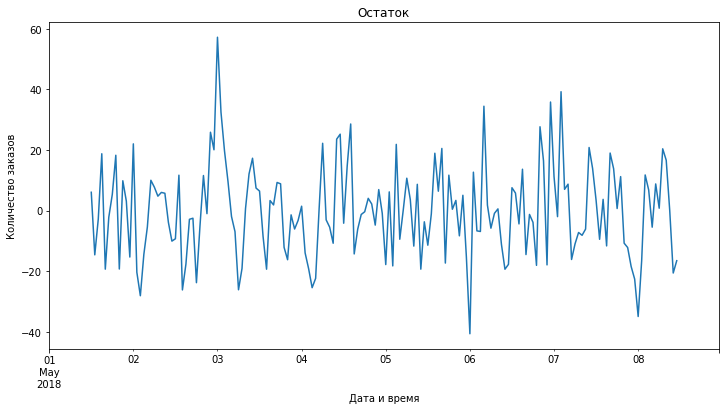

In [12]:
decomposed_data = seasonal_decompose(data['2018-05-01':'2018-05-08'])
plt.figure(figsize=(12, 6))
decomposed_data.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.figure(figsize=(12, 6))
decomposed_data.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.figure(figsize=(12, 6))
decomposed_data.resid.plot(ax=plt.gca()) 
plt.title('Остаток')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.show()

С помощью скользящего среднего и скользящего среднего отклонения посмотрим значения, которые меньше всего подвержены колебаниям

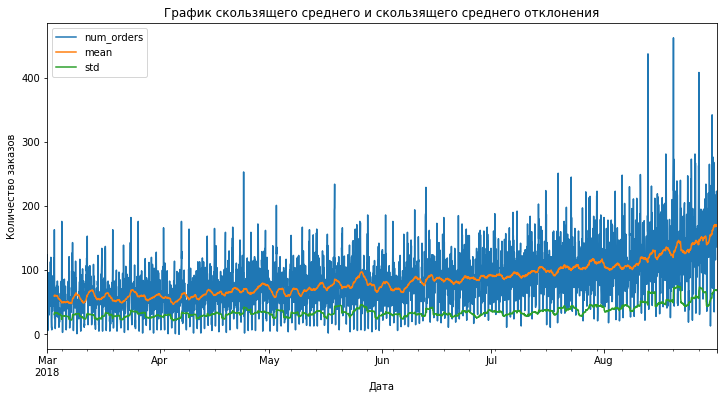

In [13]:
data['mean'] = data['num_orders'].rolling(48).mean()
data['std'] = data['num_orders'].rolling(48).std()
data.plot(figsize=(12, 6))
plt.title('График скользящего среднего и скользящего среднего отклонения')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Из графиков видно, что:
- Дисперсия увеличичвается
- Тренд в общем растет, то есть кол-во заказов и пользователей растет
- Количество заказов в раннее утром - невелико
- Пик заказов приходится на вечер-ночь
- Ближе к окночанию временного ряда видим участившиеся и услившиеся выбросы и волатильность.

    Временной ряд в нашем случае не является стационарным, так как подвержен тренду, который меняется во времени.

Стационарные временные ряды (англ. stationary time series) — это ряды, у которых среднее и стандартное отклонение не меняются.

In [14]:
data = data.drop(['mean', 'std'], axis=1)

### Подготовка данных

Подготовим параметры с помощью функции. Разобьем параметры на следующие виды:

- Календарные признаки (день, день недели, час)

- Отстающие значения

- Скользящее среднее

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data_copy = data.copy()
    data_copy['month'] = data_copy.index.day
    data_copy['dayofweek'] = data_copy.index.dayofweek
    data_copy['hour'] = data_copy.index.hour
    for lag in range(1, max_lag + 1):
        data_copy['lag_{}'.format(lag)] = data_copy['num_orders'].shift(lag)
    data_copy['rolling_mean'] = data_copy['num_orders'].shift().rolling(rolling_mean_size).mean()

    return data_copy

In [16]:
new_data = make_features(data, 48, 72)
new_data.head()

,num_orders,month,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
train, temp = train_test_split(new_data, test_size=0.2, shuffle=False)
valid, test = train_test_split(temp, test_size=0.5, shuffle=False)

train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

print('Размер обучающей выборки ', features_train.shape)
print('Размер валидационной выборки _valid ', features_valid.shape)
print('Размер тестовой выборки ', features_test.shape)

Размер обучающей выборки  (3460, 52)
Размер валидационной выборки _valid  (442, 52)
Размер тестовой выборки  (442, 52)


### Промежуточный вывод

Данные проанализированны, можно сделать следующие выводы:

1. Минимальное количество заказов - 0
2. Максимальное - 462
3. Данные - сводка по 184 дням и 23 часам
4. Дисперсия увеличичвается
5. Тренд в общем растет, то есть кол-во заказов и пользователей растет
6. Количество заказов в раннее утром - невелико
7. Пик заказов приходится на вечер-ночь
8. Ближе к окночанию временного ряда видим участившиеся и услившиеся выбросы и волатильность.
9. Временной ряд в нашем случае не является стационарным, так как подвержен тренду, который меняется во времени.
10. Проведена подготовка данных, были добавлены следующие параметры:
- Календарные признаки(день, день недели, час)
- Отстающие значения
- Скользящее среднее

11. Разделили данные на 3 выборки

## Обучение

Чтобы использовать кроссвалидацию для подбора гиперпараметоров в качестве аргумента cv будем использовать специальный сплиттер TimeSeriesSplit, который не будет нарушать порядок следования данных.

In [18]:
tscv = TimeSeriesSplit(n_splits=8)

### Случайный лес

In [19]:
%%time
model = RandomForestRegressor()
params = {
    'n_estimators' : range(60, 100, 10),
    'max_depth' : range(15, 30, 5),
    'random_state' : [12345]
    }
grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')
grid_cv.fit(features_train, target_train)
rf_params = grid_cv.best_params_
rf_rmse = (-grid_cv.best_score_) ** 0.5
print('Лучшие гипперпараметры: ', rf_params)
print('RMSE: {:.2f}'.format(rf_rmse))

Лучшие гипперпараметры:  {'max_depth': 20, 'n_estimators': 90, 'random_state': 12345}
RMSE: 22.36
CPU times: user 4min 52s, sys: 277 ms, total: 4min 52s
Wall time: 4min 53s


In [20]:
%%time
model_rf = RandomForestRegressor(**rf_params)
model_rf.fit(features_train, target_train)

CPU times: user 7.28 s, sys: 39.9 ms, total: 7.32 s
Wall time: 7.33 s


RandomForestRegressor(max_depth=20, n_estimators=90, random_state=12345)

In [21]:
%%time
predict_rf = model_rf.predict(features_valid)

CPU times: user 23.7 ms, sys: 0 ns, total: 23.7 ms
Wall time: 30.2 ms


In [22]:
rmse_rf = mean_squared_error(target_valid, predict_rf)**0.5

print('RMSE: {:.2f}'.format(rmse_rf))

RMSE: 32.67


### LightGBM

In [23]:
%%time
model = LGBMRegressor()
params = {
    'boosting_type' : ['gbdt'],
    'n_estimators' : [50, 100, 200],
    'max_depth' : [5, 7, 10, 12],
    'verbose' : [-1],
    'random_state' : [12345],
    'force_col_wise': [True],
    'num_leaves' : [30, 130, 200]
    }
grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')
grid_cv.fit(features_train, target_train)
lgb_params = grid_cv.best_params_
lgb_rmse = (-grid_cv.best_score_) ** 0.5
print('Лучшие гипперпараметры: ', lgb_params)
print('RMSE: {:.2f}'.format(lgb_rmse))

Лучшие гипперпараметры:  {'boosting_type': 'gbdt', 'force_col_wise': True, 'max_depth': 7, 'n_estimators': 50, 'num_leaves': 30, 'random_state': 12345, 'verbose': -1}
RMSE: 22.33
CPU times: user 24min 13s, sys: 11.4 s, total: 24min 25s
Wall time: 24min 35s


In [24]:
%%time
model_lgb = LGBMRegressor(**lgb_params)
model_lgb.fit(features_train, target_train)

CPU times: user 849 ms, sys: 0 ns, total: 849 ms
Wall time: 888 ms


LGBMRegressor(force_col_wise=True, max_depth=7, n_estimators=50, num_leaves=30,
              random_state=12345, verbose=-1)

In [25]:
%%time
predict_lgb = model_lgb.predict(features_valid)

CPU times: user 20.4 ms, sys: 0 ns, total: 20.4 ms
Wall time: 89.5 ms


In [26]:
rmse_lgb = mean_squared_error(target_valid, predict_lgb)**0.5
print('RMSE:{:.2f}'.format(rmse_lgb))

RMSE:30.77


### Промежуточный вывод

Мы обучили несколько моделей с разными параметрами:

1. Случайный лес
   - Лучшие гипперпараметры:  {'max_depth': 20, 'n_estimators': 90, 'random_state': 12345}
   - RMS на тренировочной выборке: 22.36
   - RMSE на валидационной выборке: 32.67
   - Время обучения: 7.33 s
   - Время предсказания: 30.2 ms

2. LightGBM
   - Лучшие гипперпараметры:  {'boosting_type': 'gbdt', 'force_col_wise': True, 'max_depth': 7, 'n_estimators': 50, 'num_leaves': 30, 'random_state': 12345, 'verbose': -1}
   - RMSE на тренировочной выборке: 22.33
   - RMSE на валидационной выборке: 30.77
   - Время обучения: 888 ms
   - Время предсказания: 89.5 ms
   
Лучшей моделью оказалась LightGBM с гипперпараметры {'boosting_type': 'gbdt', 'force_col_wise': True, 'max_depth': 7, 'n_estimators': 50, 'num_leaves': 30, 'random_state': 12345, 'verbose': -1}

## Тестирование

Протестируем лучшую модель

In [27]:
predict_lgb_test = model_lgb.predict(features_test)
rmse_lgb_test = mean_squared_error(target_test, predict_lgb_test)**0.5
print('RMSE: {:.2f}'.format(rmse_lgb_test))

RMSE: 47.90


Значение RMSE на тестовой выборке меньше 48 - тестирование пройдено

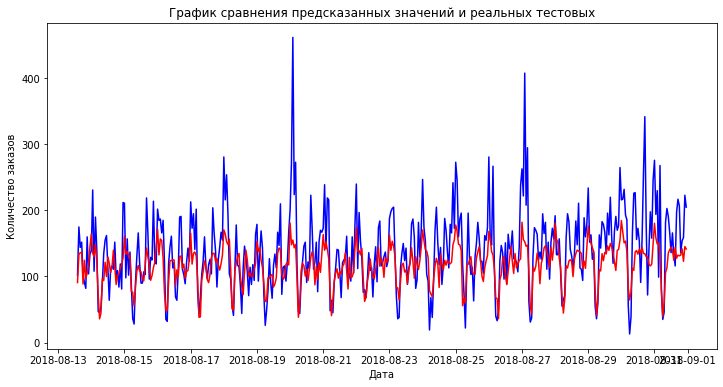

In [32]:
plt.figure(figsize=(12, 6))
plt.title('График сравнения предсказанных значений и реальных тестовых')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.plot(np.array(target_test.index), np.array(target_test), 'b-', np.array(target_test.index), np.array(predict_lgb_test),'r-')
plt.show;

## Вывод

В данном проекте мы создавали модель для предсказания количества заказов такси на следующий час. Для этого были выполнены следующие шаги:

1. Подготовка
    1. В нашем распоряжении данные от 2018-03-01 00:00:00 до 2018-08-31 23:00:00
    2. Данные хранятся в хронологическом порядке
    3. Проведено ресемплирование данных по одному часу
2. Анализ
    1. Минимальное количество заказов - 0
    2. Максимальное - 462
    3. Данные - сводка по 184 дням и 23 часам
    4. Дисперсия увеличичвается
    5. Тренд в общем растет, то есть кол-во заказов и пользователей растет
    6. Количество заказов в раннее утром - невелико
    7. Пик заказов приходится на вечер-ночь
    8. Ближе к окночанию временного ряда видим участившиеся и услившиеся выбросы и волатильность.
    9. Временной ряд в нашем случае не является стационарным, так как подвержен тренду, который меняется во времени.
    10. Проведена подготовка данных, были добавлены следующие параметры:
    - Календарные признаки(день, день недели, час)
    - Отстающие значения
    - Скользящее среднее

    11. Разделили данные на 3 выборки
3. Обучение
   
   Мы обучили несколько моделей с разными параметрами:

    1. Случайный лес
       - Лучшие гипперпараметры:  {'max_depth': 25, 'n_estimators': 90, 'random_state': 12345}
       - RMSE на тренировочной выборке: 23.32
       - RMSE на валидационной выборке: 40.07
       - Время обучения: 15.5 s
       - Время предсказания: 19ms
    
    2. LightGBM
       - Лучшие гипперпараметры:  {'boosting_type': 'gbdt', 'force_col_wise': True, 'max_depth': 10, 'n_estimators': 50, 'num_leaves': 30, 'random_state': 12345, 'verbose': -1}
       - RMSE на тренировочной выборке: 23.26
       - RMSE на валидационной выборке: 39.92
       - Время обучения: 79.7 ms
       - Время предсказания: 3.53 ms
    
    Лучшей моделью оказалась LightGBM с гипперпараметры {'boosting_type': 'gbdt', 'force_col_wise': True, 'max_depth': 10, 'n_estimators': 50, 'num_leaves': 30, 'random_state': 12345, 'verbose': -1}
4. Тестирование

   1. Тестирование лучшей модели прошло успешно, показетили RMSE на тестовой выборке: 45.25 
   
   2. Был построен график сравнения предсказанных значений и реальных тестовых